In [1]:
import numpy
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np
map_base_dir = "C:\\Users\\wish4\\OneDrive\\Desktop\\buildingsegment"
map_img_dir = "C:\\Users\\wish4\\OneDrive\\Desktop\\buildingsegment\\train\\images"

In [2]:
json_path = os.path.join(map_base_dir, "C:\\Users\\wish4\\OneDrive\\Desktop\\buildingsegment\\annotation.json\\annotation.json")
with open(json_path, 'r') as f:
    annot_data = json.load(f)

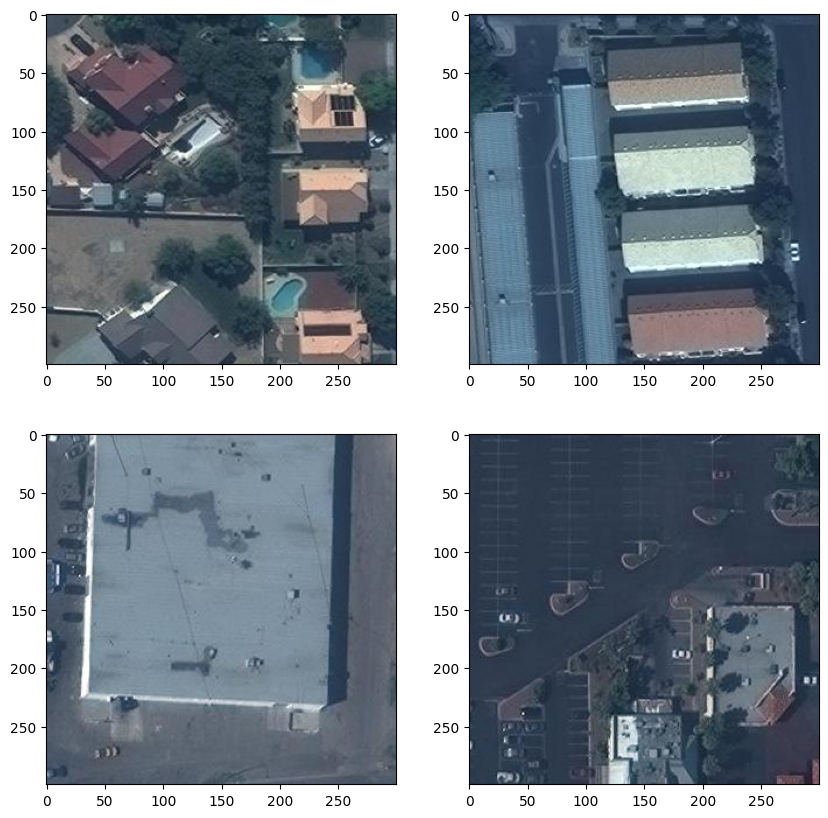

In [3]:
image_df = pd.DataFrame(annot_data['images'])
image_df.sample(3)
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (_, c_row) in zip(m_axs.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(os.path.join(map_img_dir, c_row['file_name']))
    c_ax.imshow(img_data)

In [4]:
annot_df = pd.DataFrame(annot_data['annotations'])
annot_df.sample(3)

id  image_id                                       segmentation  \
1396463  1911672    224276  [[53.999999999999986, 33.0, 46.999999999999986...   
875525   1584163    185825  [[300.0, 261.0, 293.0, 261.0, 293.0, 227.99999...   
1980319   281735     33000  [[287.0, 300.0, 287.0, 296.0, 279.0, 296.0, 27...   

           area                                               bbox  \
1396463    63.0  [33.0, 46.999999999999986, 20.999999999999986,...   
875525    588.0  [227.99999999999997, 283.0, 72.00000000000003,...   
1980319  5894.0                         [216.0, 215.0, 84.0, 85.0]   

         category_id  iscrowd  
1396463          100        0  
875525           100        0  
1980319          100        0

In [5]:
full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(image_df.shape[0], '+', annot_df.shape[0], '->', full_df.shape[0])
full_df.sample(2)

280741 + 2395553 -> 2395553


id_x  image_id                                       segmentation  \
787835    579629     68076  [[282.0, 300.0, 282.0, 291.0, 299.0, 291.0, 29...   
1256695  1523337    178702  [[50, 116, 53, 179, 9, 180, 8, 169, 0, 170, 0,...   

           area                        bbox  category_id  iscrowd    id_y  \
787835    153.0  [282.0, 282.0, 18.0, 17.0]          100        0   68076   
1256695  3162.0             [8, 0, 172, 53]          100        0  178702   

                file_name  width  height  
787835   000000068076.jpg    300     300  
1256695  000000178702.jpg    300     300

In [6]:
def create_boxes(in_rows):
    #TODO: this seems to get a few of the boxes wrong so we stick to segmentation polygons instead
    box_list = []
    for _, in_row in in_rows.iterrows():
        # bbox from the coco standard
        (start_y, start_x, wid_y, wid_x) = in_row['bbox']
        
        box_list += [Rectangle((start_x, start_y), 
                         wid_y , wid_x
                         )]
    return box_list

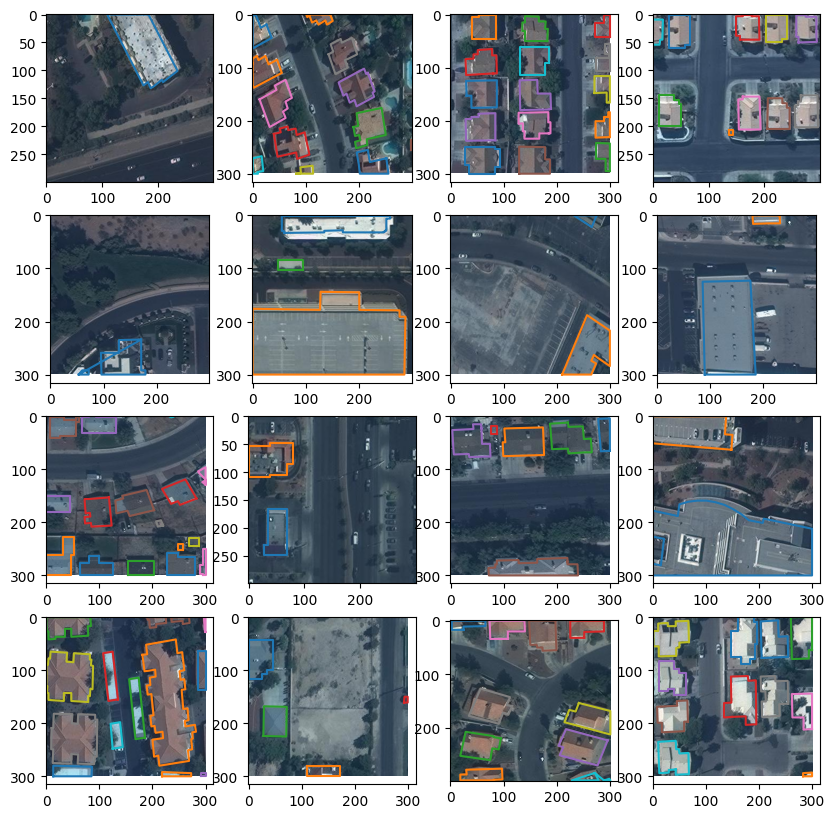

In [7]:
fig, m_axs = plt.subplots(4, 4, figsize = (10, 10))
for c_ax, (c_id, c_df) in zip(m_axs.flatten(), full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    #c_ax.add_collection(PatchCollection(create_boxes(c_df), alpha = 0.25, facecolor = 'red'))
    for _, c_row in c_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])

In [9]:
from matplotlib.path import Path
from skimage.color import label2rgb
def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]), 
                range(in_img.shape[1]),
               indexing='ij')
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(), 
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

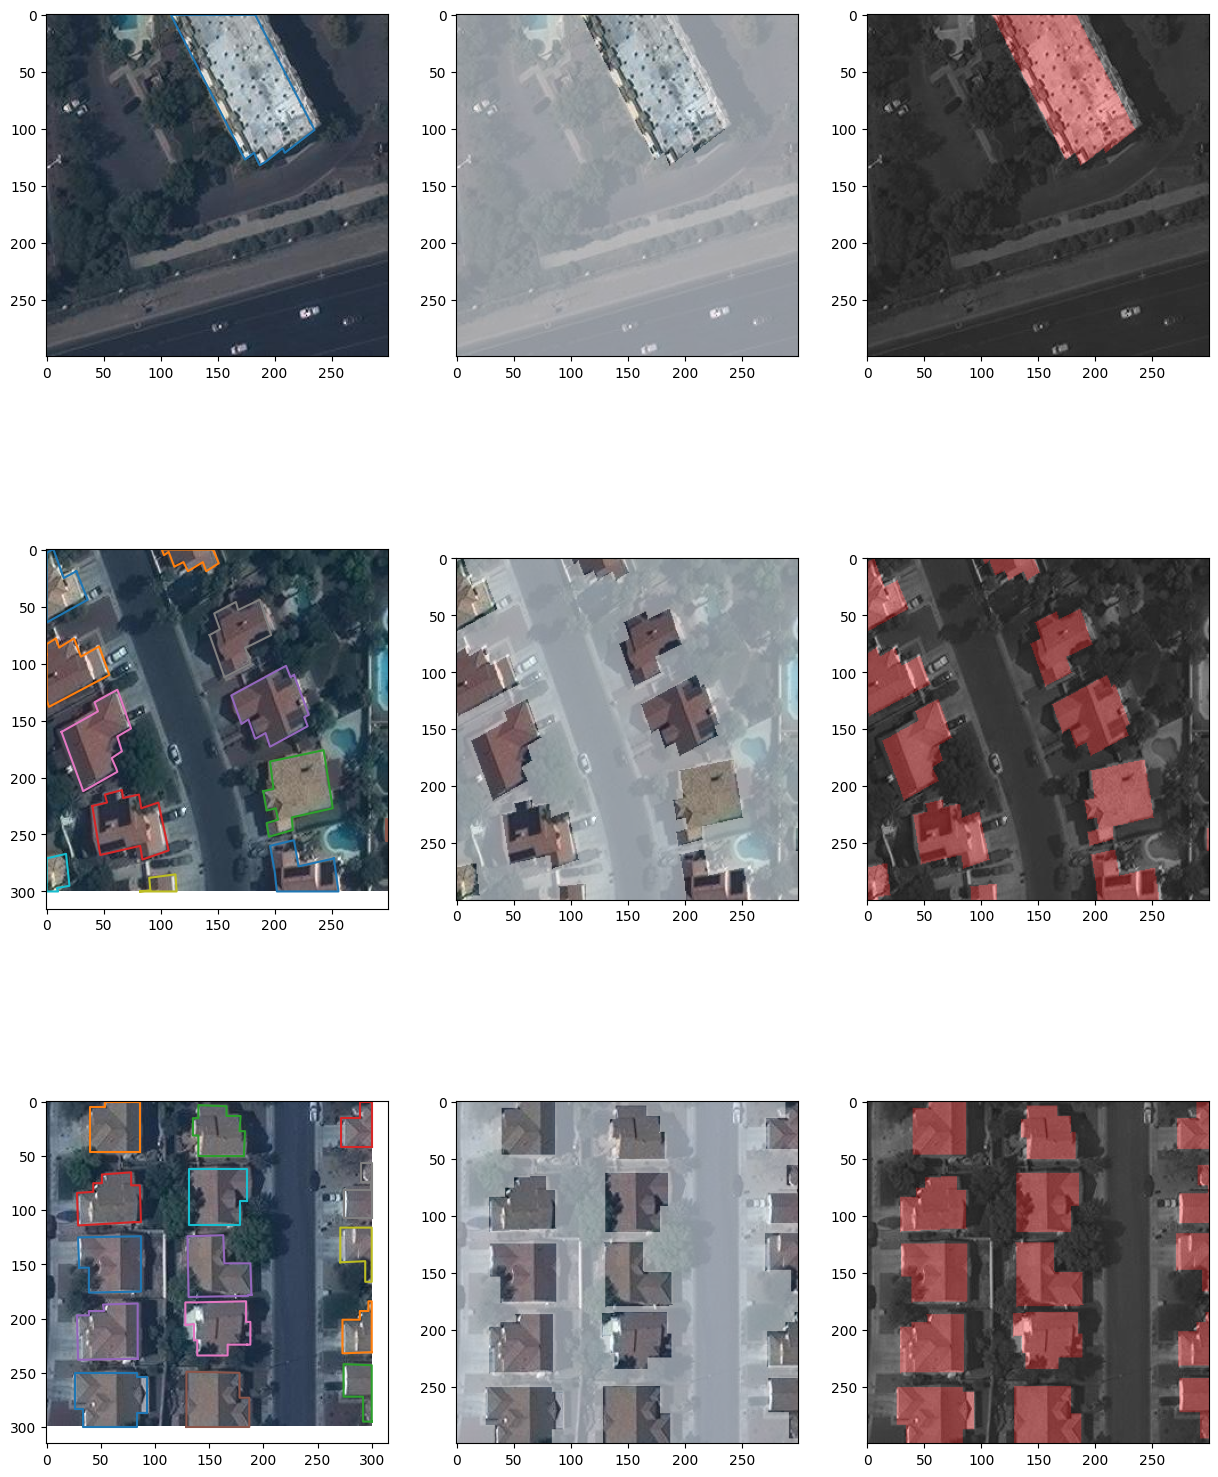

In [10]:
fig, m_axs = plt.subplots(3, 3, figsize = (15, 20))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs,
                                      full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    out_img = rows_to_segmentation(img_data, c_df)
    rgba_img = np.concatenate([img_data, 
                               np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)
                              ], -1)
    d_ax.imshow(rgba_img)
    
    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label = 0))

In [11]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(image_df['id'], test_size = 0.25)
train_df = full_df[full_df['image_id'].isin(train_ids)]
valid_df = full_df[full_df['image_id'].isin(valid_ids)]
print(train_df.shape[0], 'training boxes')
print(valid_df.shape[0], 'validation boxes')

1797365 training boxes
598188 validation boxes


In [12]:
def batch_img_gen(in_df, batch_size):
    all_groups = list(in_df.groupby('image_id'))
    out_img, out_seg = [], []
    while True:
        for (_, c_df) in np.random.permutation(all_groups):
            img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
            out_img += [img_data]
            out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]
            if len(out_img)>=batch_size:
                yield (np.stack(out_img, 0)/255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)
                out_img, out_seg = [], []
valid_gen = batch_img_gen(valid_df, 8)

C:\Users\wish4\AppData\Local\Temp\ipykernel_13336\3766723584.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


x (8, 300, 300, 3) float32 0.0 1.0
y (8, 300, 300, 1) float32 0.0 1.0


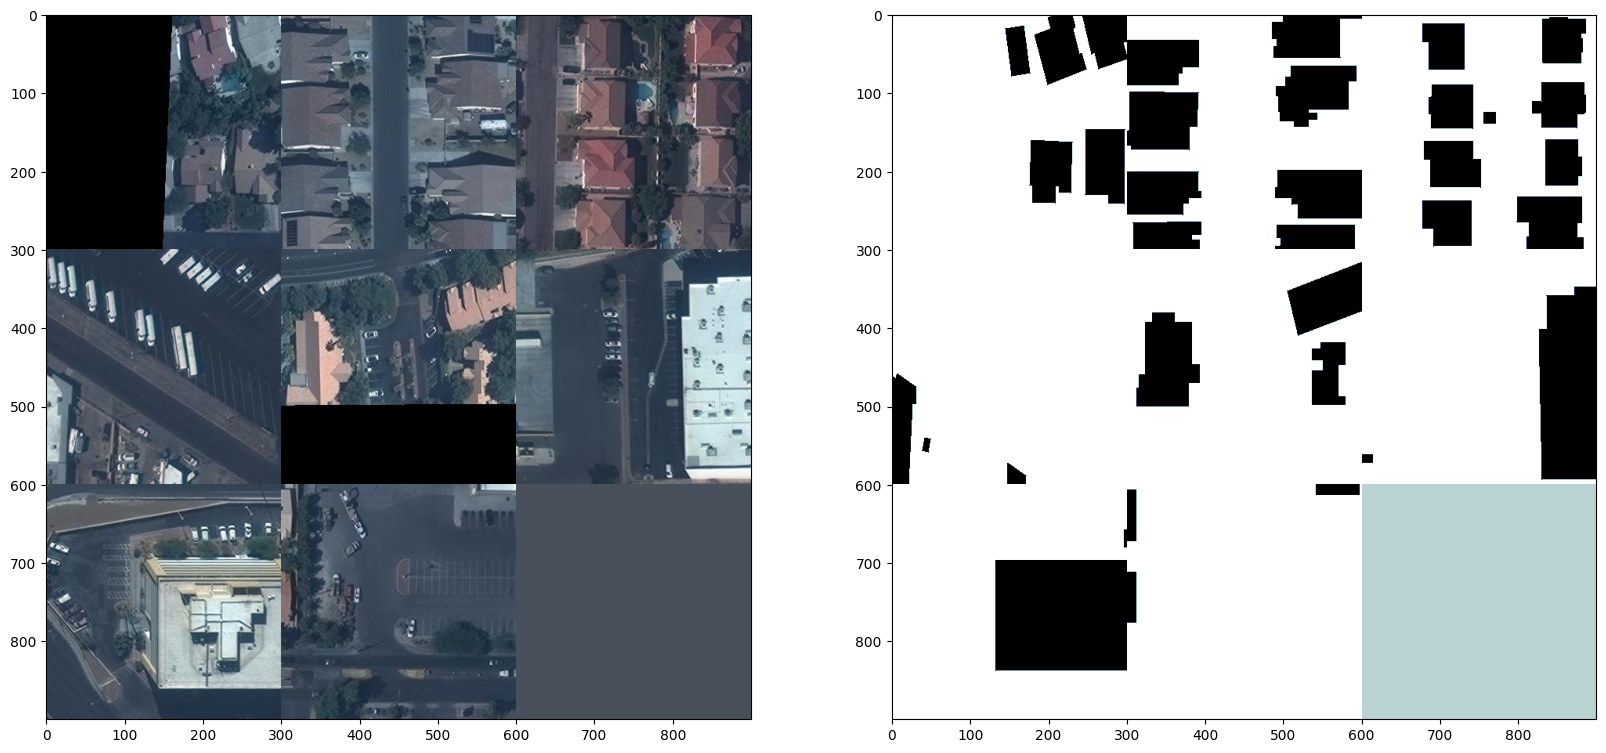

In [13]:
from skimage.util import montage as montage2d
t_x, t_y = next(valid_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')

In [14]:
BLOCK_COUNT = 1
EDGE_CROP = 16
BASE_DEPTH = 16
SPATIAL_DROPOUT = 0.25
GAUSSIAN_NOISE = 0.1
BATCH_SIZE = 24

In [15]:
from keras import models, layers
def conv_bn(x, filt, dl_rate=(1,1), preblock = False):
    y = layers.Convolution2D(filt, (3, 3), 
                             activation='linear', 
                             padding='same', 
                             dilation_rate=dl_rate,
                            use_bias=False)(x)
    if preblock: return y
    y = layers.BatchNormalization()(y)
    return layers.Activation('elu')(y)

in_layer = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c = conv_bn(pp_in_layer, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH)

skip_layers = [pp_in_layer]
for j in range(BLOCK_COUNT):
    depth_steps = int(np.log2(t_x.shape[1])-2)
    d = layers.concatenate(skip_layers+[conv_bn(c, BASE_DEPTH*2**j, (2**i, 2**i), preblock=True) 
                                        for i in range(depth_steps)])
    d = layers.SpatialDropout2D(SPATIAL_DROPOUT)(d)
    d = layers.BatchNormalization()(d)
    d = layers.Activation('elu')(d)
    # bottleneck
    d = conv_bn(d, BASE_DEPTH*2**(j+1))
    skip_layers += [c]
    c = d
d = layers.Convolution2D(1, (1, 1), activation='sigmoid', padding='same')(d)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
seg_model = models.Model(inputs = [in_layer],
                    outputs = [d])
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 RGB_Input (InputLayer)      [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 gaussian_noise (GaussianNo  (None, 300, 300, 3)          0         ['RGB_Input[0][0]']           
 ise)                                                                                             
                                                                                                  
 batch_normalization (Batch  (None, 300, 300, 3)          12        ['gaussian_noise[0][0]']      
 Normalization)                                                                                   
                                                                                              

In [16]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
import tensorflow as tf
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 0.05*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4, decay=1e-6),
    loss=dice_p_bce,
    metrics=[dice_coef, "binary_accuracy", true_positive_rate],
)

In [17]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [18]:
valid_gen = batch_img_gen(valid_df, BATCH_SIZE)
loss_history = [seg_model.fit_generator(batch_img_gen(train_df, BATCH_SIZE), 
                             steps_per_epoch=min(train_ids.shape[0]//BATCH_SIZE, 100),
                             epochs=2, 
                             validation_data = valid_gen,
                             validation_steps = min(train_ids.shape[0]//BATCH_SIZE, 50),
                             callbacks=callbacks_list,
                            workers=1)]

C:\Users\wish4\AppData\Local\Temp\ipykernel_13336\271455657.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = [seg_model.fit_generator(batch_img_gen(train_df, BATCH_SIZE),
C:\Users\wish4\AppData\Local\Temp\ipykernel_13336\3766723584.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


Epoch 1/2
100/100 [==============================] - ETA: 0s - loss: -0.3787 - dice_coef: 0.4492 - binary_accuracy: 0.7213 - true_positive_rate: 0.6377 

C:\Users\wish4\AppData\Local\Temp\ipykernel_13336\3766723584.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):



Epoch 1: val_dice_coef improved from -inf to 0.42104, saving model to seg_model_weights.best.hdf5
100/100 [==============================] - 1205s 12s/step - loss: -0.3787 - dice_coef: 0.4492 - binary_accuracy: 0.7213 - true_positive_rate: 0.6377 - val_loss: -0.3397 - val_dice_coef: 0.4210 - val_binary_accuracy: 0.6277 - val_true_positive_rate: 0.7394 - lr: 1.0000e-04
Epoch 2/2
100/100 [==============================] - ETA: 0s - loss: -0.3962 - dice_coef: 0.4712 - binary_accuracy: 0.7308 - true_positive_rate: 0.6526 
Epoch 2: val_dice_coef improved from 0.42104 to 0.47849, saving model to seg_model_weights.best.hdf5
100/100 [==============================] - 1178s 12s/step - loss: -0.3962 - dice_coef: 0.4712 - binary_accuracy: 0.7308 - true_positive_rate: 0.6526 - val_loss: -0.4099 - val_dice_coef: 0.4785 - val_binary_accuracy: 0.7483 - val_true_positive_rate: 0.6310 - lr: 1.0000e-04


In [19]:
seg_model.load_weights(weight_path)
seg_model.save('full_best_model.h5')

c:\Users\wish4\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


x (16, 300, 300, 3) float32 0.0 1.0
y (16, 300, 300, 1) float32 0.0 1.0
1/1 [==============================] - 1s 1s/step


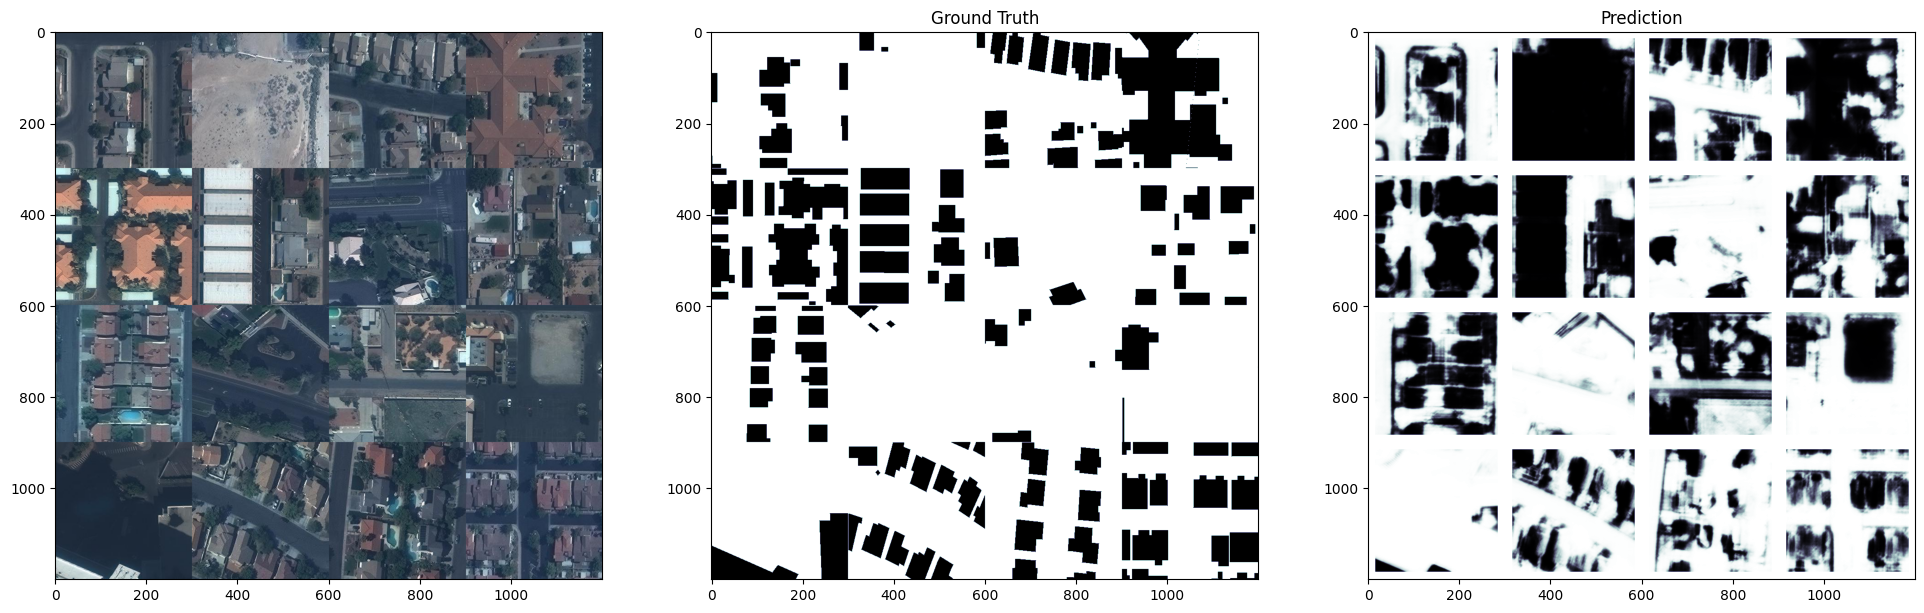

In [20]:
t_x, t_y = next(valid_gen)
if t_x.shape[0]>16:
    t_x = t_x[:16]
    t_y = t_y[:16]
    
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
pred_y = seg_model.predict(t_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')
ax2.set_title('Ground Truth')
ax3.imshow(montage2d(pred_y[:, :, :, 0]), cmap = 'bone_r')
ax3.set_title('Prediction')
fig.savefig('pred_fig.png', dpi=300)